# DIBRD Challenge on AIcrowd
#### Author : Gaétan Ramet

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

## Load Data
We use pandas library to load our data. Pandas loads them into dataframes which helps us analyze our data easily. Learn more about it [here](https://www.tutorialspoint.com/python_data_science/python_pandas.htm)

In [2]:
train_data_path = "data/train.csv" #path where data is stored

In [3]:
train_data = pd.read_csv(train_data_path,header=None) #load data in dataframe using pandas

## Visualise the Dataset

In [4]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,75,63,60,55,48,35,13.195493,4.396967,0.104070,0.000000,0.000000,0.000000,0.000000,0.000000,0.513092,0.123966,0,1
1,1,1,79,76,74,72,69,50,61.559348,28.959444,12.778104,2.045287,0.038016,0.000000,0.000000,0.000000,0.527993,0.101884,0,1
2,1,1,41,41,40,40,38,35,6.090116,0.834492,0.027460,0.000000,0.000000,0.000000,0.000000,0.000000,0.506881,0.091535,1,0
3,1,1,17,16,16,14,12,9,75.438535,20.352500,5.237412,0.206817,0.003884,0.000971,0.000971,0.000971,0.544614,0.089329,1,1
4,1,1,63,63,63,59,57,48,13.558211,5.366467,0.604079,0.051511,0.000000,0.000000,0.000000,0.000000,0.552941,0.112387,0,1


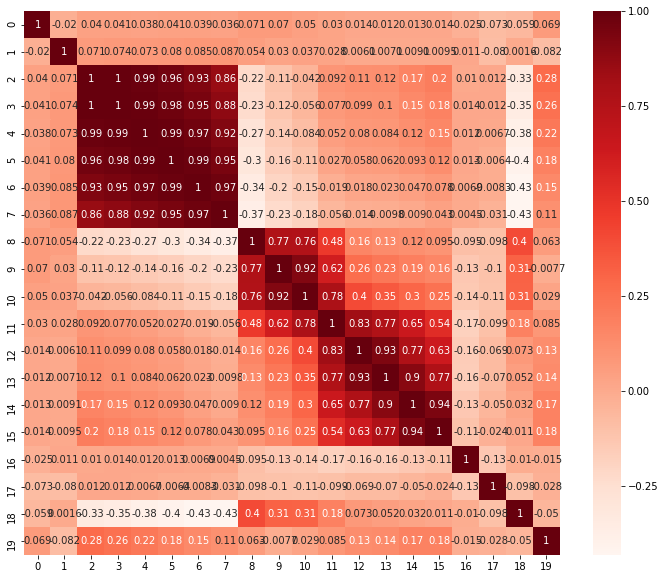

In [5]:
plt.figure(figsize=(12,10))
cor = train_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

You can see the columns goes from 0 to 19, where columns from 0 to 18 represents features extracted from the image set and last column represents the type of patient i.e 1 if if signs of Diabetic Retinopathy is present else 0.

## Split Data into Train and Validation
Now we want to see how well our classifier is performing, but we dont have the test data labels with us to check. What do we do ? So we split our dataset into train and validation. The idea is that we test our classifier on validation set in order to get an idea of how well our classifier works. This way we can also ensure that we dont [overfit](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/) on the train dataset. There are many ways to do validation like [k-fold](https://machinelearningmastery.com/k-fold-cross-validation/),[leave one out](https://en.wikipedia.org/wiki/Cross-validation_(statistics), etc

In [6]:
X_train, X_val= train_test_split(train_data, test_size=0.2, random_state=42) 

Here we have selected the size of the testing data to be 20% of the total data. You can change it and see what effect it has on the accuracies. To learn more about the train_test_split function [click here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Now, since we have our data splitted into train and validation sets, we need to get the label separated from the data.

In [7]:
from sklearn.preprocessing import StandardScaler

def preprocess(X, labels=True, scaler=None):
    if labels:
        X, y = X.iloc[:,:-1], X.iloc[:,-1]

    X = X.drop([0], axis=1)
    #X = X.drop([8,9,10], axis =1)

    print(X.skew())
    for num in [8,9,10,11,12,13,14,15]:
        #Skewed variables
        #X['1/{}'.format(num)] = X[num].apply(lambda x : 1/x if x != 0 else x)
        X['sqrt({})'.format(num)] = X[num]**0.5
        X['log({})'.format(num)] = X[num].apply(lambda x : np.log(x) if x > 0 else -10)
    X = X.drop([8,9,10,11,12,13,14,15], axis=1)

    X = X.drop([1,16,17,18], axis=1)# '1/8', '1/9', '1/10', '1/11', '1/12', '1/13', '1/14'])
    cols = list(X.columns)
    for i, num in enumerate(cols):
        for num2 in cols[i:]:
            X['{}*{}'.format(num, num2)] = X[num] * X[num2]

    if scaler is None:
        ret_scaler = True
        scaler = StandardScaler()
        scaler.fit(X)
        #scaler.fit(X[[2,3,4,5,6,7,16,17]])
    else:
        ret_scaler = False

    #X[[2,3,4,5,6,7,16,17]] = scaler.transform(X[[2,3,4,5,6,7,16,17]])
    X[:] = scaler.transform(X[:])

    if labels:
        if ret_scaler:
            return X,y,scaler
        else:
            return X, y
    else:
        return X

X_train, y_train, scaler = preprocess(X_train)
X_val, y_val = preprocess(X_val, scaler=scaler)

#for col in X_train.columns:
#    plt.figure()
#    sns.distplot(X_train[col])

#all_data = X_train.copy()
#all_data['label'] = y_train
#plt.figure(figsize=(24,20))
#cor = all_data.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()



1     -3.168142
2      0.626903
3      0.511510
4      0.442875
5      0.438933
6      0.487053
7      0.708219
8      1.827179
9      2.306228
10     3.196974
11     6.617131
12    11.561347
13    11.994999
14     8.669752
15     8.200151
16    -0.304079
17     0.756210
18     0.717234
dtype: float64
1    -2.364407
2     0.763900
3     0.658998
4     0.558204
5     0.536706
6     0.574784
7     0.645623
8     1.199401
9     1.812191
10    1.586239
11    1.938787
12    4.911526
13    4.561544
14    5.472155
15    5.733674
16   -0.178043
17    0.600054
18    0.721668
dtype: float64


## Define the Classifier
Now we come to the juicy part. We have fixed our data and now we train a classifier. The classifier will learn the function by looking at the inputs and corresponding outputs. There are a ton of classifiers to choose from some being [Logistic Regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc), [SVM](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47), [Random Forests](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47), [Decision Trees](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052), etc.   
Tip: A good model doesnt depend solely on the classifier but on the features(columns) you choose. So make sure to play with your data and keep only whats important. 

In [77]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
classifier = BaggingClassifier(LogisticRegression(C=0.5, solver = 'liblinear',multi_class='auto',max_iter=1000, penalty='l2'))
#classifier = XGBClassifier()
##classifier = SVC(gamma=2, C=1)
#classifier = SVC(kernel='poly', C=0.025)
#classifier = AdaBoostClassifier(n_estimators=200)
#classifier = GradientBoostingClassifier(n_estimators=1000)
#classifier = RandomForestClassifier(n_estimators=1000)
#classifier = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(100,100), activation='tanh', max_iter=200))

We have used [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) as a classifier here and set few of the parameteres. But one can set more parameters and increase the performance. To see the list of parameters visit [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

We can also use other classifiers. To read more about sklean classifiers visit [here](https://scikit-learn.org/stable/supervised_learning.html). Try and use other classifiers to see how the performance of your model changes.

## Train the classifier

In [78]:
classifier.fit(X_train, y_train)


BaggingClassifier(base_estimator=LogisticRegression(C=0.5, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None,
                                                    max_iter=1000,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=No

Got a warning! Dont worry, its just beacuse the number of iteration is very less(defined in the classifier in the above cell).Increase the number of iterations and see if the warning vanishes and also see how the performance changes.Do remember increasing iterations also increases the running time.( Hint: max_iter=500)

## Predict on Validation
Now we predict our trained classifier on the validation set and evaluate our model# Predict on test set

In [79]:
y_pred = classifier.predict(X_val)

## Evaluate the Performance
We use the same metrics as that will be used for the test set.  
[F1 score](https://en.wikipedia.org/wiki/F1_score) are the metrics for this challenge

In [80]:
precision = precision_score(y_val,y_pred,average='micro')
recall = recall_score(y_val,y_pred,average='micro')
accuracy = accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,average='macro')

In [81]:
print("Accuracy of the model is :" ,accuracy)
print("Recall of the model is :" ,recall)
print("Precision of the model is :" ,precision)
print("F1 score of the model is :" ,f1)

Accuracy of the model is : 0.7717391304347826
Recall of the model is : 0.7717391304347826
Precision of the model is : 0.7717391304347826
F1 score of the model is : 0.7707641196013288


# Prediction on Evaluation Set

In [82]:
#Full training

train_data_full, train_label_full, scaler = preprocess(train_data)
classifier.fit(train_data_full, train_label_full)

pred_full = classifier.predict(train_data_full)

precision = precision_score(train_label_full,pred_full,average='micro')
recall = recall_score(train_label_full,pred_full,average='micro')
accuracy = accuracy_score(train_label_full,pred_full)
f1 = f1_score(train_label_full,pred_full,average='macro')

print("Accuracy of the model is :" ,accuracy)
print("Recall of the model is :" ,recall)
print("Precision of the model is :" ,precision)
print("F1 score of the model is :" ,f1)

1     -2.961096
2      0.663008
3      0.551811
4      0.473272
5      0.463522
6      0.506135
7      0.695082
8      1.709906
9      2.229258
10     3.047623
11     6.968177
12    12.493043
13    13.071475
14     9.070248
15     8.486215
16    -0.274047
17     0.724573
18     0.716941
dtype: float64
Accuracy of the model is : 0.7934782608695652
Recall of the model is : 0.7934782608695652
Precision of the model is : 0.7934782608695652
F1 score of the model is : 0.7934431188671041


## Load Test Set
Load the test data now# Load the evaluation data

In [83]:
final_test_path = "data/test.csv"
final_test = pd.read_csv(final_test_path,header=None)

final_test = preprocess(final_test, labels=False, scaler=scaler)

1    -3.544965
2     0.983094
3     0.837941
4     0.705661
5     0.601136
6     0.614782
7     0.798545
8     1.403738
9     1.795985
10    2.654856
11    3.275933
12    5.553527
13    5.899895
14    6.489058
15    8.271266
16    0.173025
17    1.093323
18    0.623046
dtype: float64


## Predict Test Set
Time for the moment of truth! Predict on test set and time to make the submission.

In [84]:
submission = classifier.predict(final_test)

## Save the prediction to csv

In [85]:
submission = pd.DataFrame(submission)
submission.to_csv('results/submission_3.csv',header=['label'],index=False)

Note: Do take a look at the submission format.The submission file should contain a header.For eg here it is "label". 